# EDA: Digging into the Frequency and Severity of the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [15]:
motor_df = pd.read_csv('../data/input/exp/Motor_vehicle_insurance_data.csv', delimiter=";")
sample_df = pd.read_csv('../data/input/exp/sample_type_claim.csv', delimiter=';')

### Claims Frequency Distribution - 2 methods documented

- Number: Categorical group for number of claims ranging from 0 to 25 (maximum number of claims made by 1 policyholder)
- Policies: Number of unique policies per group
- Claims: Total number of claims per group
- Proportion: Ratio of each group's policies to total number of policies.

#### Method 1 - Readable

In [16]:
combined  =  pd.merge(motor_df, sample_df, on='ID', how='left')
bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
labels = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24+']

In [36]:
claims_count_per_policy = pd.cut(combined
                                 .rename(columns={'N_claims_year':'claims_grouping'})['claims_grouping'], bins=bins, labels=labels)

grouping = (combined
            .groupby(claims_count_per_policy, observed=True)
            # for each policy-holder, how many claims  have they made between the time range of the dataset
            .agg({'ID': 'nunique', 'N_claims_year': 'sum'})
            .rename(columns={'ID': 'Policies', 'N_claims_year': 'Claims'})
            .reset_index()
            )

##Calculate grouping proportion
grouping['Proportion'] = (grouping['Policies'] / grouping['Policies'].sum()).round(4)

## Summing and appending as a row
length_of_grouping = len(grouping)
grouping.loc[length_of_grouping] = ['Sum', grouping['Policies'].sum(), grouping['Claims'].sum(), grouping['Proportion'].sum()]

##Transpose df
grouping_transposed  = grouping.T

##clean out the columns
grouping_transposed.columns = [''] * len(grouping_transposed.columns)
grouping_transposed

,,,,,,,,,,,,,,,,,,,,,,
claims_grouping,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,24+,Sum
Policies,9464,4952,2434,1188,609,318,227,136,82,61,24,18,18,10,8,2,3,2,1,1,1,19559
Claims,9551,12102,9210,5684,3525,2118,1631,1144,882,610,264,216,234,140,120,32,51,36,19,21,25,47615
Proportion,0.4839,0.2532,0.1244,0.0607,0.0311,0.0163,0.0116,0.007,0.0042,0.0031,0.0012,0.0009,0.0009,0.0005,0.0004,0.0001,0.0002,0.0001,0.0001,0.0001,0.0001,1.0001


#### Method 2 - Chained

In [17]:
combined = pd.merge(motor_df, sample_df, on='ID', how='left')
bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
labels = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24+']


def add_sum_row(df):
    df.loc[len(df)] = ['Sum', df['Policies'].sum(), df['Claims'].sum(), df['Proportion'].sum()]
    return df

claims_frequency_summary = (
    combined.groupby(pd.cut(combined['N_claims_year'], bins=bins, labels=labels), observed=True)
    .agg({'ID': 'nunique', 'N_claims_year': 'sum'})
    .rename(columns={'ID': 'Policies', 'N_claims_year': 'Claims'})
    .reset_index()
    .rename(columns={'N_claims_year': 'Number'})
    .assign(Proportion=lambda df: (df['Policies'] / df['Policies'].sum()).round(4))
    .pipe(add_sum_row)
    .T
    .pipe(lambda df: df.rename_axis('', axis=1))
    .pipe(lambda df: df.set_axis([''] * len(df.columns), axis=1))
)
claims_frequency_summary

,,,,,,,,,,,,,,,,,,,,,,
Number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,24+,Sum
Policies,9464,4952,2434,1188,609,318,227,136,82,61,24,18,18,10,8,2,3,2,1,1,1,19559
Claims,9551,12102,9210,5684,3525,2118,1631,1144,882,610,264,216,234,140,120,32,51,36,19,21,25,47615
Proportion,0.4839,0.2532,0.1244,0.0607,0.0311,0.0163,0.0116,0.007,0.0042,0.0031,0.0012,0.0009,0.0009,0.0005,0.0004,0.0001,0.0002,0.0001,0.0001,0.0001,0.0001,1.0001


### Claims Severity Distribution - TBI

- Average severity (loss cost) made by each policyholder that initiated claims expressed in logarithimic scale
- Visual inspection and confirmation of numbers required

In [38]:
claims_summary  =  (
    sample_df[['Cost_claims_year']].drop_duplicates(keep='first') ### Sample df already aggregated the loss cost to each policyholder just need to drop duplicates
    .describe()
    .drop('count')
    .T
    .reset_index(drop=True)
)
claims_summary

,mean,std,min,25%,50%,75%,max
0,1041.265623,4930.436935,40.05,150.4,337.67,758.33,236285.18


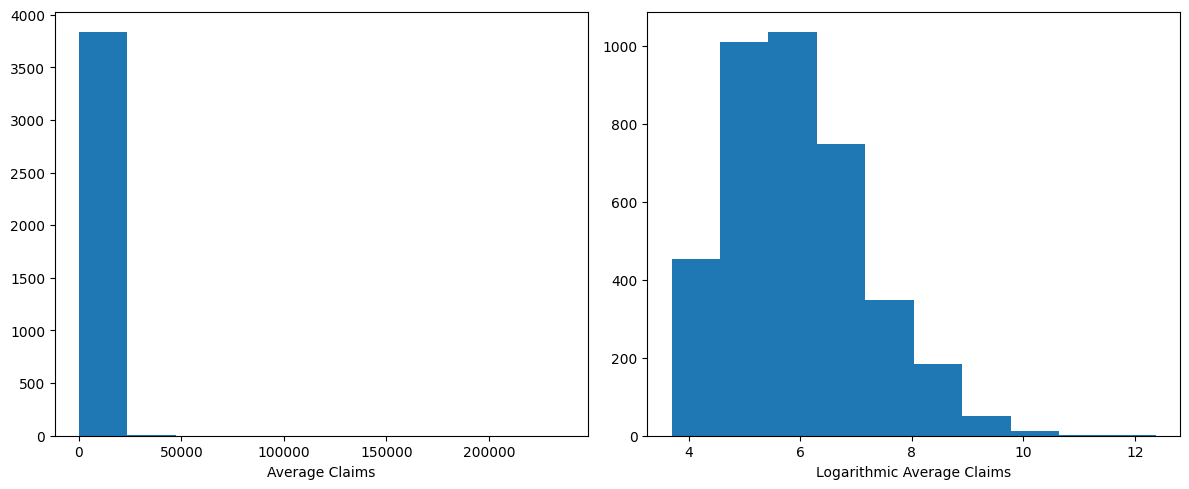

In [39]:
claims  = sample_df[['Cost_claims_year']].drop_duplicates(keep='first')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

fig, ax1.hist(claims['Cost_claims_year'])
ax1.set_xlabel("Average Claims")
ax1.set_title("")

# Histogram of log(yAvg)
ax2.hist(np.log(claims['Cost_claims_year']))
ax2.set_xlabel("Logarithmic Average Claims")
ax2.set_title("")

plt.tight_layout()
plt.show()